In [1]:
%%capture
!pip install --upgrade pip
!pip install ChannelAttribution

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import plotly.express as px

from ChannelAttribution import *
import plotly.io as pio

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
%matplotlib inline

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename));

Advertisers use a variety of online marketing channels to reach consumers and they typically want to know how much each channel contributes to their marketing success. This is what is known as multi-channel attribution. In many cases, advertisers approach this problem using some simple heuristical models that often  underestimate the importance of different marketing channels.
In general, there are different types of attribution models:

* **First Touch Conversion:** A user's conversion is attributed to the first channels/touchpoints.
* **Last Touch Conversion:** A user's conversion is attributed to the last channels/touchpoints.
* **Linear Touch Conversion:** All channels/touchpoints are given equal credit to a user's conversion.
* **Markov chains:** A probabilistic model that represents the buyer's journey as a graph, with the nodes representing different channels/touchpoints, and the connecting lines being observed transitions between them. The number of times buyers have transitioned between two states is converted into a probability, which can then be used to measure the importance of each channel and the most likely channel paths to success.

*Example Markov Chain where C denotes the marketing channel*:

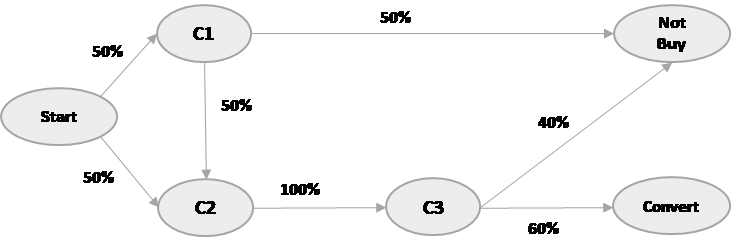

# Data
For this analysis, I used the following [dataset](http://www.dropbox.com/sh/m5d8u7inolw32xu/AADuHNcGToa7ajTcF_JjEkcca?dl=0), showing digital marketing data that one would typically encounter in a production environment. The data set contains 586,000 marketing touch-points from July (2018), comprising 240,000 unique customers who generated ~18,000 conversions. 

A more detailed description of the features is shown below:
* Cookie: Anonymous customer id enabling us to track the progression of a given customer
* Timestamp: Date and time when the visit took place
* Interaction: Categorical variable indicating the type of interaction that took place
* Conversion: Boolean variable indicating whether a conversion took place
* Conversion Value: Value of the potential conversion event (revenue)
* Channel: The marketing channel that brought the customer to our site



In [2]:
#Importing the data
df = pd.read_csv('/kaggle/input/attribution-data/attribution data.csv')
df['time'] = pd.to_datetime(df['time'])
df.head()

,cookie,time,interaction,conversion,conversion_value,channel
0,00000FkCnDfDDf0iC97iC703B,2018-07-03 13:02:11+00:00,impression,0,0.0,Instagram
1,00000FkCnDfDDf0iC97iC703B,2018-07-17 19:15:07+00:00,impression,0,0.0,Online Display
2,00000FkCnDfDDf0iC97iC703B,2018-07-24 15:51:46+00:00,impression,0,0.0,Online Display
3,00000FkCnDfDDf0iC97iC703B,2018-07-29 07:44:51+00:00,impression,0,0.0,Online Display
4,0000nACkD9nFkBBDECD3ki00E,2018-07-03 09:44:57+00:00,impression,0,0.0,Paid Search


# Simple EDA

In [3]:
#Plotting conversions over time by channel
conversions = df.loc[df['conversion'] == 1]
conversions['time'] = conversions['time'].dt.date
conversions = conversions[conversions['time']< pd.to_datetime("2018-7-30").date()]
conversions.drop(columns = ['cookie', 'interaction'], inplace = True)
conversions = conversions.groupby(['time','channel'], as_index=False).sum()

fig = px.line(conversions, x='time', y='conversion', color='channel')

fig.update_layout(title='Channel Conversions over Time',
                   xaxis_title='Conversions',
                   yaxis_title='Date')
fig.show()

# Data Pre-processing

In [4]:
#Creating the path order for when users interact with different channels (this is equivalent to SQL window functions)
df['path_order'] = df.sort_values(['time']).groupby(['cookie']).cumcount() + 1
df.head()

,cookie,time,interaction,conversion,conversion_value,channel,path_order
0,00000FkCnDfDDf0iC97iC703B,2018-07-03 13:02:11+00:00,impression,0,0.0,Instagram,1
1,00000FkCnDfDDf0iC97iC703B,2018-07-17 19:15:07+00:00,impression,0,0.0,Online Display,2
2,00000FkCnDfDDf0iC97iC703B,2018-07-24 15:51:46+00:00,impression,0,0.0,Online Display,3
3,00000FkCnDfDDf0iC97iC703B,2018-07-29 07:44:51+00:00,impression,0,0.0,Online Display,4
4,0000nACkD9nFkBBDECD3ki00E,2018-07-03 09:44:57+00:00,impression,0,0.0,Paid Search,1


In [5]:
#Aggregating the channels a user interacted with into a single row
df_paths = df.groupby('cookie')['channel'].agg(lambda x: x.tolist()).reset_index()
df_paths = df_paths.rename(columns={"channel": "path"})
df_paths.head()

,cookie,path
0,00000FkCnDfDDf0iC97iC703B,"[Instagram, Online Display, Online Display, On..."
1,0000nACkD9nFkBBDECD3ki00E,"[Paid Search, Paid Search, Paid Search, Paid S..."
2,0003EfE37E93D0BC03iBhBBhF,"[Paid Search, Paid Search, Paid Search, Paid S..."
3,00073CFE3FoFCn70fBhB3kfon,[Instagram]
4,00079hhBkDF3k3kDkiFi9EFAD,[Paid Search]


In [6]:
#Looking at the last interaction to see if it led to a user converting
df_last_interaction = df.drop_duplicates('cookie', keep='last')[['cookie', 'conversion', 'conversion_value']]
df_last_interaction.head()

,cookie,conversion,conversion_value
3,00000FkCnDfDDf0iC97iC703B,0,0.0
9,0000nACkD9nFkBBDECD3ki00E,0,0.0
14,0003EfE37E93D0BC03iBhBBhF,0,0.0
15,00073CFE3FoFCn70fBhB3kfon,0,0.0
16,00079hhBkDF3k3kDkiFi9EFAD,0,0.0


In [7]:
#Concatinating with the dataframes of user path's
df_paths = pd.merge(df_paths, df_last_interaction, how='left', on='cookie')
df_paths.head()

,cookie,path,conversion,conversion_value
0,00000FkCnDfDDf0iC97iC703B,"[Instagram, Online Display, Online Display, On...",0,0.0
1,0000nACkD9nFkBBDECD3ki00E,"[Paid Search, Paid Search, Paid Search, Paid S...",0,0.0
2,0003EfE37E93D0BC03iBhBBhF,"[Paid Search, Paid Search, Paid Search, Paid S...",0,0.0
3,00073CFE3FoFCn70fBhB3kfon,[Instagram],0,0.0
4,00079hhBkDF3k3kDkiFi9EFAD,[Paid Search],0,0.0


In [8]:
print('Total conversions: {}'.format(sum(df.conversion)))
print('Total conversion rate: {}%'.format(round(sum(df.conversion) / len(df)*100)))
print('Total value of conversions: ${}'.format(round(sum(df.conversion_value))))
print('Average conversion value: ${}'.format(round(sum(df.conversion_value) / sum(df.conversion))))

Total conversions: 17639
Total conversion rate: 3%
Total value of conversions: $110231
Average conversion value: $6


In [9]:
#We will create a variable ‘path’ in the specific formatrequired by the Attribution Model where the ordered channels a user interacts with are delimited by'>'
def listToString(df):  
    str1 = ""  
    for i in df['path']:  
        str1 += i + ' > '    
    return str1[:-3]

df_paths['path'] = df_paths.apply(listToString, axis=1)
df_paths.head()

,cookie,path,conversion,conversion_value
0,00000FkCnDfDDf0iC97iC703B,Instagram > Online Display > Online Display > ...,0,0.0
1,0000nACkD9nFkBBDECD3ki00E,Paid Search > Paid Search > Paid Search > Paid...,0,0.0
2,0003EfE37E93D0BC03iBhBBhF,Paid Search > Paid Search > Paid Search > Paid...,0,0.0
3,00073CFE3FoFCn70fBhB3kfon,Instagram,0,0.0
4,00079hhBkDF3k3kDkiFi9EFAD,Paid Search,0,0.0


In [10]:
#Removing the user's cookie and grouping by the path to see the how many times a specific combination of channels led to a conversion or null outcome
df_paths.drop(columns = 'cookie', inplace = True)
df_paths['null'] = np.where(df_paths['conversion'] == 0,1,0)

attribution_df = df_paths.groupby(['path'], as_index = False).sum()
attribution_df.rename(columns={"conversion": "total_conversions", "null": "total_null", "conversion_value": "total_conversion_value"}, inplace = True)
attribution_df.sample(10)

,path,total_conversions,total_conversion_value,total_null
3364,Facebook > Online Display > Paid Search > Paid...,0,0.0,1
6010,Instagram > Paid Search > Online Display > Onl...,1,7.5,0
6786,Online Display > Online Display > Online Displ...,1,7.0,1
4250,Instagram > Facebook > Facebook > Facebook > F...,0,0.0,1
9962,Paid Search > Online Display > Paid Search > O...,0,0.0,1
2395,Facebook > Instagram > Facebook > Facebook > I...,0,0.0,1
7952,Online Video > Online Display > Online Video >...,0,0.0,1
10900,Paid Search > Paid Search > Paid Search > Onli...,0,0.0,3
1071,Facebook > Facebook > Facebook > Online Displa...,0,0.0,4
2976,Facebook > Instagram > Instagram > Online Vide...,1,6.5,0


# Attribution Modelling

In [11]:
#Now, we will use the ChannelAttribution package to create the attribution models described above

#Heuristic models
H=heuristic_models(attribution_df,"path","total_conversions",var_value="total_conversion_value")

#Markov Models
M=markov_model(attribution_df, "path", "total_conversions", var_value="total_conversion_value")

Number of simulations: 100000 - Convergence reached: 1.58% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (48) is reached: 99.99%


In [12]:
R=pd.merge(H,M,on="channel_name",how="inner")
R1=R[["channel_name","first_touch_conversions","last_touch_conversions",\
"linear_touch_conversions","total_conversions"]]
R1.columns=["channel_name","first_touch","last_touch","linear_touch","markov_model"]

R1=pd.melt(R1, id_vars="channel_name")

data = [dict(type = "histogram", histfunc="sum",x = R1.channel_name, y = R1.value,
             transforms = [dict(type = "groupby", groups = R1.variable,)],)]

fig = dict({"data":data}) 
pio.show(fig,validate=False)

The bar chart above shows how many conversions were attributed to each channel for each model (i.e. first_touch, last_touch, etc.). Analyzing the graph, specifically the markov_model in comparison to the other methods, you can gain insights as to the relative importance of different marketing channels.
For the first touch, last touch and linear touch models, Facebook and Paid Search are the most import channels driving conversions while Instagram and Online Display are the least important. However, according to the Markov Model, Instagram is far more important to our conversions than our simple attribution models suggest - indeed according to the probabilistic model it is infact our third most important channel.

Similar to the total conversions bar chart, a revenue bar chart can be created highlighting the revenue attributed to each channel.

In [13]:
R2=R[["channel_name","first_touch_value","last_touch_value",\
"linear_touch_value","total_conversion_value"]]
R2.columns=["channel_name","first_touch","last_touch","linear_touch","markov_model"]

R2=pd.melt(R2, id_vars="channel_name")
data = [dict(type = "histogram", histfunc="sum", x = R2.channel_name, y = R2.value,
             transforms = [dict(type = "groupby",groups = R2.variable,)],)]

fig = dict({"data":data})
pio.show(fig,validate=False)

As expected, the total revenue attributed to each channel corresponds to the number of conversions that it generates.

To get an idea of how the different channels affect a user's journeys we can also look at the transition probability matrix, which can be visualized in a heatmap.

In [14]:
transition_matrix = transition_matrix(attribution_df, "path", "total_conversions", var_null="total_null")

In [15]:
matrix = transition_matrix['transition_matrix']
matrix = pd.pivot_table(matrix, values='transition_probability', index=['channel_from'],
                    columns=['channel_to'], aggfunc=np.sum)

column_dict = transition_matrix['channels'].set_index('id_channel')['channel_name'].to_dict()
keys_values = column_dict.items()
column_dict = {str(key): str(value) for key, value in keys_values}

matrix = matrix.rename(mapper=column_dict, axis=1).rename(mapper=column_dict, axis=0)
matrix.fillna(0, inplace = True)

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 <a list of 7 Text major ticklabel objects>)

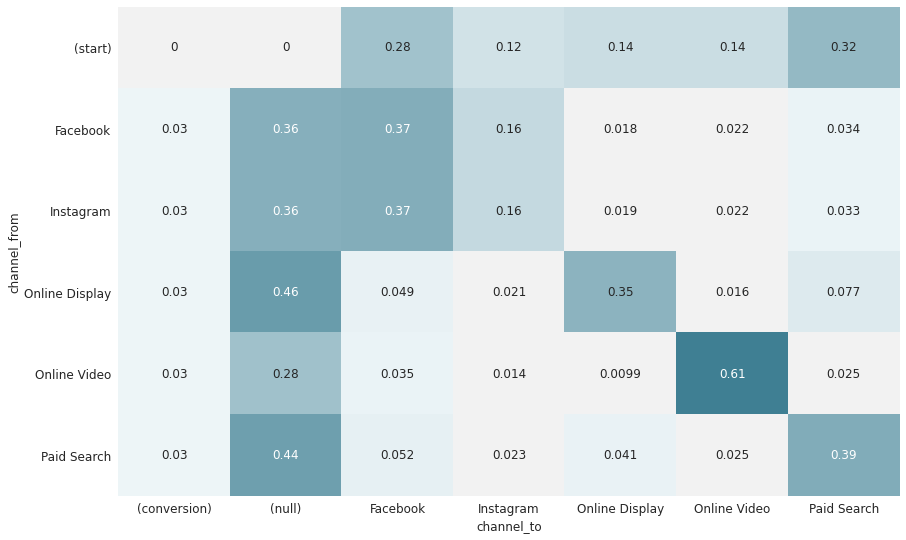

In [16]:
#Heat map for transition probabilities in the data set
fig = plt.figure(figsize = (14,9))
style.use('ggplot')
sns.set_style('whitegrid')

sns.heatmap(matrix, cmap=sns.diverging_palette(20, 220, n=200), annot=True, center = 0,\
            annot_kws={'size':12}, cbar=False)
plt.yticks(rotation=0, fontsize = 12)
plt.xticks(fontsize = 12)

# Conclusions

Using the heat map and the plots above we not only gain insights into how each marketing channel is driving conversions, but we also gain critical information around how our  channels are interacting with each other, driving users one channel to another. Given the number of touchpoints a user today typically faces, this information can prove to be extremely valuable and allows us to optimize our multi-channel customer journeys accordingly. Using the Markov Chain approach outlined in this article will allow your attributions to more accurately reflect how your users are interacting with your marketing.